In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glicko2 import Player
import random
import torch

In [1]:
!pip install glicko2

In [ ]:
# # Setup
# np.random.seed(2)

# # Number of arms
# n = 200

# # Number of matches between the optimal arm and suboptimal arms
# m = 1

# # Assume Normal Noise
# delta = 0.2
# sigma = 1
# theta = np.asarray([1, 1-delta, 1-delta/2])
# last_dim = n/20
# mu = [0.5] + [0.5-delta]*(n-1)

# # Initialize Players
# players = {}
# arms = {}

# for i in range(n):

#     arm = np.asarray([.2- .2*i/n, .8, 0.0])
#     if i == 0:
#         arm = np.asarray([1.0, 0.0, 0.0])
#     if i > 0 and i <= last_dim:
#         arm = np.asarray([0, .1*i/n, 1.0])
#     arm /= np.sum(arm)
#     arms[i] = arm
#     players[i] = Player()

In [191]:
# Setup
np.random.seed(42)

# Number of dimensions
d = 5

# Assume Normal noise
sigma = 1

# Optimal dimension is the first one
delta = 0.2
theta = [1]
theta += [1-delta]*(d-1)
theta = np.asarray(theta)


# Number of arms in worst dimension
n = 1000

# Number of arms in suboptimal dimensions
m = 5

# Number of matches between arm 0 and each arm
a = 1

# Initialize Players
players = {}
arms = {}
ind = 0
def create_arm(d, i, num, arms, ind):
    for _ in range(num):
        arm = np.random.uniform(size = d)
        if i == d:
          for j in range(1, d):
            arm[j] = 0
        arm[i] += 50
        arm /= np.sum(arm)
        arms[ind] = arm
        players[ind] = Player()
        ind += 1
    return arms, ind

for i in range(d):
    if i == 0:
        arms, ind = create_arm(d, i, 1, arms, ind)
    elif i < d-1:
        arms, ind = create_arm(d, i, m, arms, ind)
    else:
        arms, ind = create_arm(d, i, n, arms, ind)

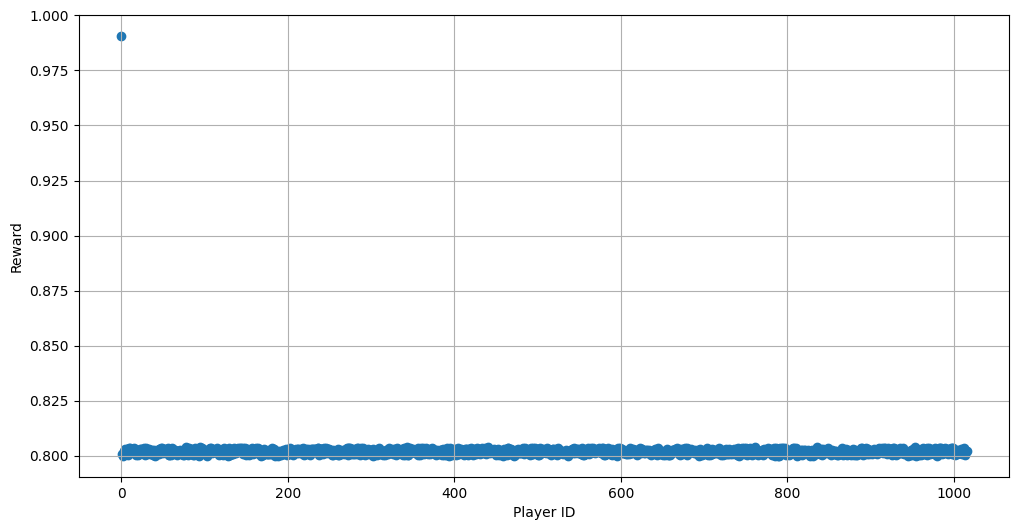

In [192]:
# Display the rewards of the arms
plt.figure(figsize=(12, 6))
plt.scatter([i for i in range(ind)], [theta@arms[i] for i in range(ind)])
plt.xlabel("Player ID")
plt.ylabel("Reward")
plt.grid(True)
plt.savefig('reward_fcn.png')
plt.show()

In [193]:
# --- Data Collection for the Rating Period ---
# This structure will hold, for each player, lists of:
# - ratings of opponents they played against
# - RDs of opponents they played against
# - outcomes of those games (1 for win, 0 for loss for the player in question)
# All ratings/RDs are taken *before* any updates in this period.
# Cutoff is 2
cutoff = 0
period_games_data = {player_id: {'opponent_ratings': [], 'opponent_rds': [], 'outcomes': []} for player_id in range(ind)}
raw_match_log = [] # Optional: to store raw [p1, p2, winner] for debugging or other analysis

# Simulate Matches and Collect Data
for i in range(1, ind):  # Optimal arm (0) plays against each suboptimal arm (i)
    for _ in range(a): # m matches between arm 0 and arm i
        # Get current ratings and RDs of players involved (these are their "pre-period" stats for this batch of games)
        opt =  random.randint(0, 0)
        rating_player_opt = players[opt].getRating()
        rd_player_opt = players[opt].getRd()
        rating_player_i = players[i].getRating()
        rd_player_i = players[i].getRd()

        # Simulate one game outcome
        performance_player_opt = np.random.normal(theta@arms[opt], sigma)
        performance_player_i = np.random.normal(theta@arms[i], sigma)

        if performance_player_opt > performance_player_i: # Player 0 wins
            winner_id = opt
            # Data for Player 0
            period_games_data[opt]['opponent_ratings'].append(rating_player_i)
            period_games_data[opt]['opponent_rds'].append(rd_player_i)
            period_games_data[opt]['outcomes'].append(1) # Player 0 won

            # Data for Player i
            period_games_data[i]['opponent_ratings'].append(rating_player_opt)
            period_games_data[i]['opponent_rds'].append(rd_player_opt)
            period_games_data[i]['outcomes'].append(0)
        else: # Player i wins
            winner_id = i
            # Data for Player 0
            period_games_data[opt]['opponent_ratings'].append(rating_player_i)
            period_games_data[opt]['opponent_rds'].append(rd_player_i)
            period_games_data[opt]['outcomes'].append(0) # Player 0 lost

            # Data for Player i
            period_games_data[i]['opponent_ratings'].append(rating_player_opt)
            period_games_data[i]['opponent_rds'].append(rd_player_opt)
            period_games_data[i]['outcomes'].append(1) # Player i won

        raw_match_log.append([opt, i, winner_id])

In [194]:
# --- Update Ratings for All Players After the Period ---
for player_id in range(ind):
    if period_games_data[player_id]['opponent_ratings']: # Check if the player played any games
        players[player_id].update_player(
            period_games_data[player_id]['opponent_ratings'],
            period_games_data[player_id]['opponent_rds'],
            period_games_data[player_id]['outcomes']
        )


In [195]:
# Extract Glicko-2 scores, RDs, and volatilities
ratings = []
rds = []
vols = []

for i in range(ind):
    ratings.append(players[i].getRating())
    rds.append(players[i].getRd())
    vols.append(players[i].vol)

# Create a Pandas DataFrame for easier viewing
results_df = pd.DataFrame({
    'PlayerID': list(range(ind)),
    'Rating': ratings,
    'RD': rds,
    'Volatility': vols
})

print("Glicko-2 Results (Processed as a single period):")
print(results_df.sort_values('Rating', ascending=False))

Glicko-2 Results (Processed as a single period):
      PlayerID       Rating          RD  Volatility
8            8  1662.310895  290.318965        0.06
9            9  1662.310895  290.318965        0.06
10          10  1662.310895  290.318965        0.06
1            1  1662.310895  290.318965        0.06
1006      1006  1662.310895  290.318965        0.06
...        ...          ...         ...         ...
334        334  1337.689105  290.318965        0.06
333        333  1337.689105  290.318965        0.06
332        332  1337.689105  290.318965        0.06
298        298  1337.689105  290.318965        0.06
343        343  1337.689105  290.318965        0.06

[1016 rows x 4 columns]


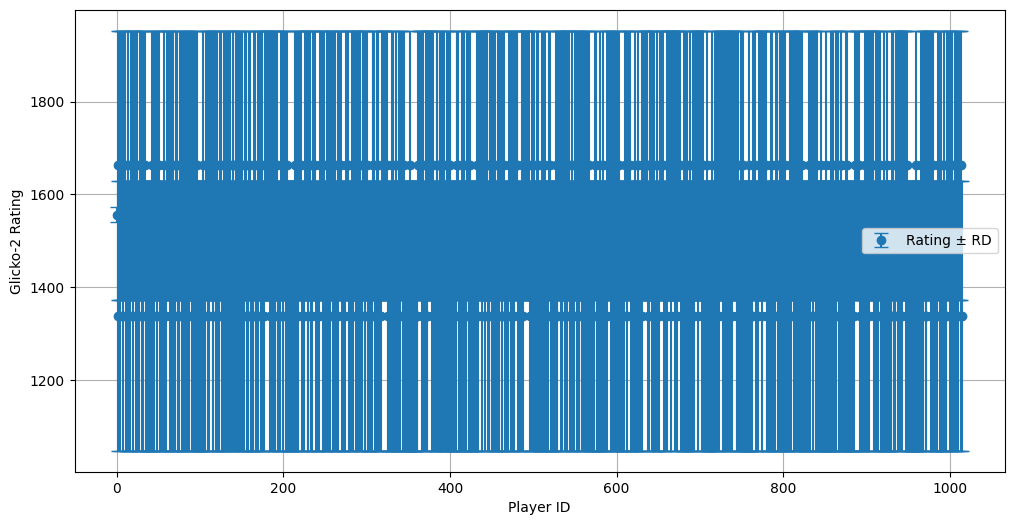

In [196]:
# Plotting the ratings
lim = ind
plt.figure(figsize=(12, 6))
plt.errorbar(results_df['PlayerID'][:lim], results_df['Rating'][:lim], yerr=results_df['RD'][:lim], fmt='o', capsize=5, label='Rating ± RD')
plt.xlabel("Player ID")
plt.ylabel("Glicko-2 Rating")
plt.legend()
plt.grid(True)
plt.savefig('glicko_eb.png')
plt.show()




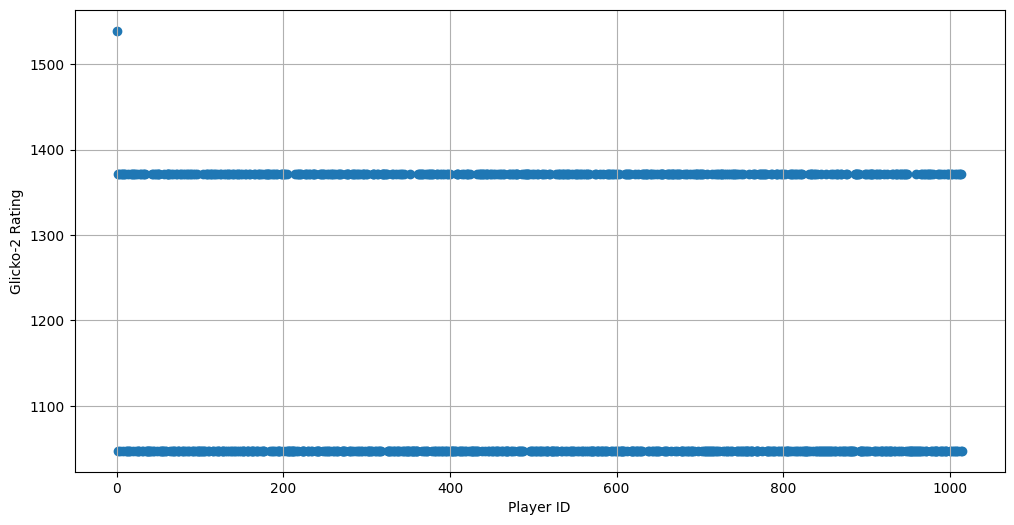

In [197]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['Rating']-results_df['RD'])
plt.xlabel("Player ID")
plt.ylabel("Glicko-2 Rating")
plt.grid(True)
plt.savefig('glicko_pess.png')
plt.show()


In [198]:
# Train a Reward Model Using the Standard Method

In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Reward Model Network using Player IDs
class RewardModel(nn.Module):
    def __init__(self, input_dim, hidden_size=100):
        super(RewardModel, self).__init__()
        # Embedding layer to learn a vector representation for each player ID
        self.fc1 = nn.Linear(input_dim, hidden_size) # Input to fc1 is the embedding dimension
        self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_size, hidden_size)
        # self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1) # Output is a single reward score
    def forward(self, arms):
        # player_ids is a tensor of player IDs (long integers)
        x = self.fc1(arms)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        # x = self.relu2(x)
        # x = self.fc3(x)
        # return x



In [200]:
hd = d

In [201]:
# --- Prepare Data for Reward Model Training (ID-based) ---
chosen_ids_list = []
rejected_ids_list = []

# raw_match_log contains [player1_id, player2_id, winner_id]
for match in raw_match_log:
    player1_id = match[0]
    player2_id = match[1]
    winner_id = match[2]

    # Ensure IDs are integers, as they will be used as indices for embeddings
    p1_id = int(player1_id)
    p2_id = int(player2_id)
    win_id = int(winner_id)


    if win_id == p1_id:
        chosen_ids_list.append(arms[p1_id])
        rejected_ids_list.append(arms[p2_id])
    elif win_id == p2_id:
        chosen_ids_list.append(arms[p2_id])
        rejected_ids_list.append(arms[p1_id])
    else:
        # This case should ideally not happen if winner is always one of p1 or p2
        # print(f"Skipping match with unexpected winner: {match}")
        continue

# Convert lists to PyTorch tensors
chosen_ids_tensor = torch.tensor(np.asarray(chosen_ids_list), dtype=torch.float)
rejected_ids_tensor = torch.tensor(np.asarray(rejected_ids_list), dtype=torch.float)

print(f"Number of training pairs: {len(chosen_ids_tensor)}")
print(f"Shape of chosen_ids_tensor: {chosen_ids_tensor.shape}") # Should be [num_matches]
print(f"Shape of rejected_ids_tensor: {rejected_ids_tensor.shape}") # Should be [num_matches]

# Create a TensorDataset and DataLoader for batching
dataset = TensorDataset(chosen_ids_tensor, rejected_ids_tensor)
# Batch size can be tuned. Using 64 as an example.
dataloader = DataLoader(dataset, batch_size=max(1, len(dataset) // 10) if len(dataset) > 10 else len(dataset) , shuffle=True) # Ensure batch_size is at least 1
if not chosen_ids_list:
    print("Warning: No training data was prepared. Check raw_match_log and its processing.")
else:
    print(f"Using batch size: {dataloader.batch_size}")

Number of training pairs: 1015
Shape of chosen_ids_tensor: torch.Size([1015, 5])
Shape of rejected_ids_tensor: torch.Size([1015, 5])
Using batch size: 101


In [202]:
# --- Train the Reward Model (ID-based) ---
# Loss function and optimizer
# Initialize the model
# 'n' is the number of players/arms, defined in a previous cell (e.g., n=100)
reward_net = RewardModel(input_dim = len(theta), hidden_size = hd)
optimizer = optim.Adam(reward_net.parameters(), lr=0.001) # Learning rate can be tuned
num_epochs = 25  # Number of training epochs, adjust as needed
print_every_epochs = 5
print("\nStarting Reward Model Training (ID-based)...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    for chosen_batch_ids, rejected_batch_ids in dataloader:
        optimizer.zero_grad()

        # Get rewards for the chosen and rejected player IDs in the batch
        rewards_chosen = reward_net(chosen_batch_ids)
        rewards_rejected = reward_net(rejected_batch_ids)

        # Pairwise preference loss: -log(sigmoid(reward_chosen - reward_rejected))
        loss = -torch.nn.functional.logsigmoid(rewards_chosen - rewards_rejected).mean()

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches +=1

    if num_batches > 0:
        avg_epoch_loss = epoch_loss / num_batches
        if (epoch + 1) % print_every_epochs == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    elif (epoch + 1) % print_every_epochs == 0 : # Handle case where dataloader was empty after all
         print(f"Epoch [{epoch+1}/{num_epochs}], No data processed in this epoch.")


print("Reward Model Training Finished.")


Starting Reward Model Training (ID-based)...
Epoch [5/25], Loss: 0.7024
Epoch [10/25], Loss: 0.6973
Epoch [15/25], Loss: 0.6960
Epoch [20/25], Loss: 0.6922
Epoch [25/25], Loss: 0.6862
Reward Model Training Finished.


In [203]:
# Example: Score all players using their IDs
# Create a tensor of all player IDs (0 to n-1)
alist = []
for i in range(ind):
    alist.append(arms[i])
all_player_ids_tensor = torch.tensor(np.asarray(alist), dtype = torch.float)

with torch.no_grad(): # Disable gradient calculation for inference
    all_player_rewards = reward_net(all_player_ids_tensor)

# Create a DataFrame for the new scores
id_scores_df = pd.DataFrame({
    'PlayerID': np.arange(ind), # Assumes PlayerIDs are 0 to n-1
    'Reward': all_player_rewards.numpy().flatten()
})

# Merge the new scores with the existing results_df
# Remove the old score column if it exists from a previous run with feature-based model
if 'Reward' in results_df.columns:
    results_df = results_df.drop(columns=['Reward'])
if 'Reward' in results_df.columns: # Remove if re-running this cell
     results_df = results_df.drop(columns=['Reward'])

results_df = pd.merge(results_df, id_scores_df, on='PlayerID', how='left')

print("\nResults DataFrame with ID-based Reward Model Scores:")
print(results_df.sort_values('Reward', ascending=False))


Results DataFrame with ID-based Reward Model Scores:
    PlayerID       Rating          RD  Volatility    Reward
9          9  1662.310895  290.318965        0.06 -0.309648
8          8  1662.310895  290.318965        0.06 -0.310292
7          7  1337.689105  290.318965        0.06 -0.310872
6          6  1662.310895  290.318965        0.06 -0.311662
10        10  1662.310895  290.318965        0.06 -0.312827
..       ...          ...         ...         ...       ...
13        13  1337.689105  290.318965        0.06 -0.583366
12        12  1337.689105  290.318965        0.06 -0.584976
15        15  1337.689105  290.318965        0.06 -0.587210
11        11  1337.689105  290.318965        0.06 -0.588264
14        14  1662.310895  290.318965        0.06 -0.588404

[1016 rows x 5 columns]


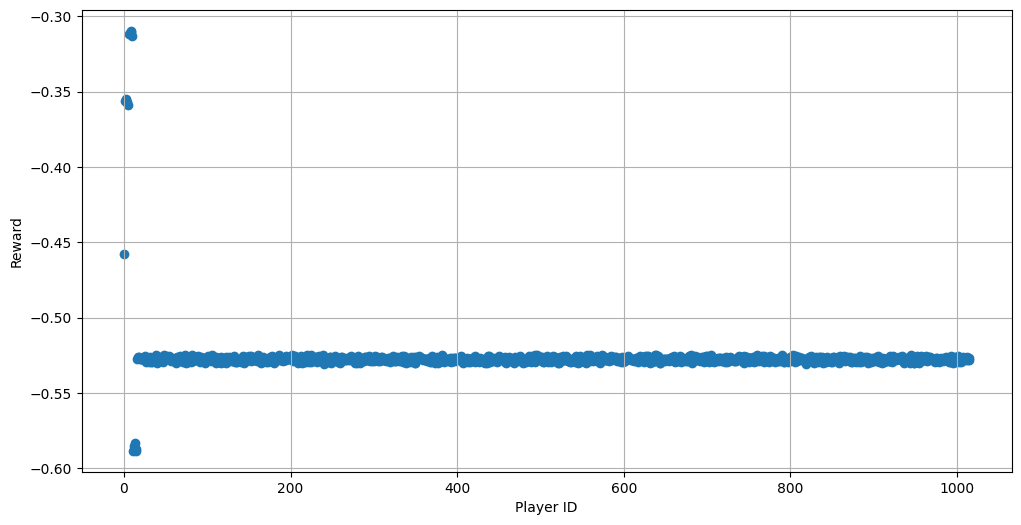

In [204]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['Reward'])
plt.xlabel("Player ID")
plt.ylabel("Reward")
plt.grid(True)
plt.savefig('nn_reward.png')
plt.show()


In [205]:
# --- Prepare Data for Regression Training (ID to Rating) ---
# The training data is now the PlayerID and their corresponding Glicko Rating
player_ids = torch.tensor([arms[i] for i in results_df['PlayerID'].values],dtype = float)
pess_target = (results_df['Rating']-results_df['RD']).values
norm_pess = pess_target - min(pess_target)
norm_pess /= max(norm_pess)

# Convert numpy arrays to PyTorch tensors
# IDs should be LongTensor for the embedding layer
# Ratings should be FloatTensor to be used as labels with MSELoss
ids_tensor = torch.tensor(player_ids, dtype=torch.float)
ratings_tensor = torch.tensor(norm_pess, dtype=torch.float32).unsqueeze(1)

print(f"Total number of samples: {len(ids_tensor)}")
print(f"Shape of ids_tensor: {ids_tensor.shape}")
print(f"Shape of ratings_tensor: {ratings_tensor.shape}")

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test)
train_ids, test_ids, train_ratings, test_ratings = train_test_split(
    ids_tensor, ratings_tensor,
    test_size=0.1,
    random_state=42,  # For reproducibility
    shuffle=True
)

print(f"\nAfter split:")
print(f"Training samples: {len(train_ids)}")
print(f"Test samples: {len(test_ids)}")
print(f"Train ratio: {len(train_ids)/len(ids_tensor):.2%}")
print(f"Test ratio: {len(test_ids)/len(ids_tensor):.2%}")

# Create separate datasets and dataloaders for training and testing
train_dataset = TensorDataset(train_ids, train_ratings)
test_dataset = TensorDataset(test_ids, test_ratings)

# Create dataloaders
batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for test

print(f"\nDataLoader info:")
print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


Total number of samples: 1016
Shape of ids_tensor: torch.Size([1016, 5])
Shape of ratings_tensor: torch.Size([1016, 1])

After split:
Training samples: 914
Test samples: 102
Train ratio: 89.96%
Test ratio: 10.04%

DataLoader info:
Training batches: 92
Test batches: 11


/tmp/ipython-input-205-1933382666.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ids_tensor = torch.tensor(player_ids, dtype=torch.float)


In [206]:
# --- Train the Network with Mean Squared Error (MSE) Loss ---
# The model 'reward_net' is used as-is from the previous cell definition
pess_net = RewardModel(input_dim = len(theta), hidden_size = hd)
print("Reward Model Network (ID-based input):")
print(pess_net)

# Loss function for regression
loss_function = nn.MSELoss()
optimizer = optim.Adam(pess_net.parameters(), lr=0.01) # A higher learning rate can sometimes work for MSE
num_epochs = 100 # Regression might need more/different epochs
print_every_epochs = 10

print("\nStarting Network Training (ID to Rating Regression)...")

# Lists to store training and test losses for tracking
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    pess_net.train()  # Set model to training mode
    epoch_train_loss = 0.0
    num_train_batches = 0

    # The dataloader now yields batches of IDs and their corresponding ratings
    for id_batch, rating_batch in train_dataloader:
        optimizer.zero_grad()
        # Get predicted ratings from the network
        predicted_ratings = pess_net(id_batch)
        # Calculate MSE loss between predicted and actual ratings
        loss = loss_function(predicted_ratings, rating_batch)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        num_train_batches += 1

    # --- Test Phase ---
    pess_net.eval()  # Set model to evaluation mode
    epoch_test_loss = 0.0
    num_test_batches = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for id_batch, rating_batch in test_dataloader:
            # Get predicted ratings from the network
            predicted_ratings = pess_net(id_batch)
            # Calculate MSE loss between predicted and actual ratings
            loss = loss_function(predicted_ratings, rating_batch)

            epoch_test_loss += loss.item()
            num_test_batches += 1

    # Calculate average losses
    avg_train_loss = epoch_train_loss / num_train_batches if num_train_batches > 0 else 0
    avg_test_loss = epoch_test_loss / num_test_batches if num_test_batches > 0 else 0

    # Store losses for tracking
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    # Print progress
    if (epoch + 1) % print_every_epochs == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train MSE: {avg_train_loss:.4f}, Test MSE: {avg_test_loss:.4f}")

print("Network Training Finished.")

# --- Final Test Error Computation ---
pess_net.eval()
final_test_loss = 0.0
num_test_samples = 0

with torch.no_grad():
    for id_batch, rating_batch in test_dataloader:
        predicted_ratings = pess_net(id_batch)
        loss = loss_function(predicted_ratings, rating_batch)
        final_test_loss += loss.item() * len(id_batch)  # Multiply by batch size for proper averaging
        num_test_samples += len(id_batch)

final_test_mse = final_test_loss / num_test_samples
final_test_rmse = torch.sqrt(torch.tensor(final_test_mse))

print(f"\n--- Final Test Performance ---")
print(f"Test MSE: {final_test_mse:.4f}")
print(f"Test RMSE: {final_test_rmse:.4f}")


Reward Model Network (ID-based input):
RewardModel(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

Starting Network Training (ID to Rating Regression)...
Epoch [10/100], Train MSE: 0.1084, Test MSE: 0.1057
Epoch [20/100], Train MSE: 0.1080, Test MSE: 0.1062
Epoch [30/100], Train MSE: 0.1080, Test MSE: 0.1058
Epoch [40/100], Train MSE: 0.1085, Test MSE: 0.1064
Epoch [50/100], Train MSE: 0.1084, Test MSE: 0.1056
Epoch [60/100], Train MSE: 0.1083, Test MSE: 0.1055
Epoch [70/100], Train MSE: 0.1082, Test MSE: 0.1059
Epoch [80/100], Train MSE: 0.1083, Test MSE: 0.1065
Epoch [90/100], Train MSE: 0.1081, Test MSE: 0.1076
Epoch [100/100], Train MSE: 0.1083, Test MSE: 0.1087
Network Training Finished.

--- Final Test Performance ---
Test MSE: 0.1087
Test RMSE: 0.3296



Results DataFrame with Predicted Glicko Ratings (MSE):
      PlayerID       Rating   pess_nn          RD  Volatility
8            8  1662.310895  0.493560  290.318965        0.06
9            9  1662.310895  0.500564  290.318965        0.06
10          10  1662.310895  0.499212  290.318965        0.06
1            1  1662.310895  0.411633  290.318965        0.06
1006      1006  1662.310895  0.335345  290.318965        0.06
...        ...          ...       ...         ...         ...
334        334  1337.689105  0.335345  290.318965        0.06
333        333  1337.689105  0.335345  290.318965        0.06
332        332  1337.689105  0.335345  290.318965        0.06
298        298  1337.689105  0.335345  290.318965        0.06
343        343  1337.689105  0.335345  290.318965        0.06

[1016 rows x 5 columns]


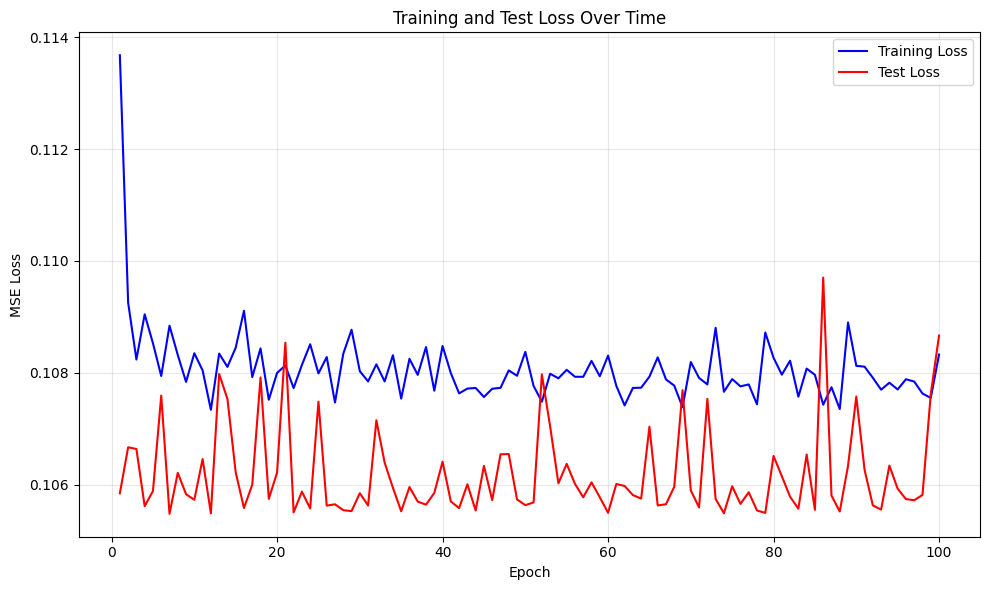


--- Test Set Analysis ---
Test Mean Absolute Error (MAE): 0.3292
Test Mean Absolute Percentage Error (MAPE): inf%
Test R² Score: -0.0235


In [207]:

# --- Evaluate the Model by Predicting Ratings for All Players ---
with torch.no_grad(): # Disable gradient calculation for inference
    predicted_ratings_all = pess_net(all_player_ids_tensor)

# Add the predicted ratings to the results_df for comparison
# First, remove old prediction columns if they exist from previous runs
for col in ['pess_nn']:
    if col in results_df.columns:
        results_df = results_df.drop(columns=[col])

results_df['pess_nn'] = predicted_ratings_all.numpy().flatten()

print("\nResults DataFrame with Predicted Glicko Ratings (MSE):")
# Display actual and predicted ratings side-by-side, sorted by the actual rating
print(results_df[['PlayerID', 'Rating', 'pess_nn', 'RD', 'Volatility']].sort_values('Rating', ascending=False))

# --- Optional: Plot Training and Test Loss Curves ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Additional Test Set Analysis ---
print(f"\n--- Test Set Analysis ---")
# Get predictions for test set only
test_predictions = []
test_actuals = []

pess_net.eval()
with torch.no_grad():
    for id_batch, rating_batch in test_dataloader:
        predicted_ratings = pess_net(id_batch)
        test_predictions.extend(predicted_ratings.numpy().flatten())
        test_actuals.extend(rating_batch.numpy().flatten())

test_predictions = torch.tensor(test_predictions)
test_actuals = torch.tensor(test_actuals)

# Calculate additional metrics
mae = torch.mean(torch.abs(test_predictions - test_actuals))
mape = torch.mean(torch.abs((test_actuals - test_predictions) / test_actuals)) * 100

print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Test R² Score: {1 - (torch.sum((test_actuals - test_predictions)**2) / torch.sum((test_actuals - torch.mean(test_actuals))**2)):.4f}")

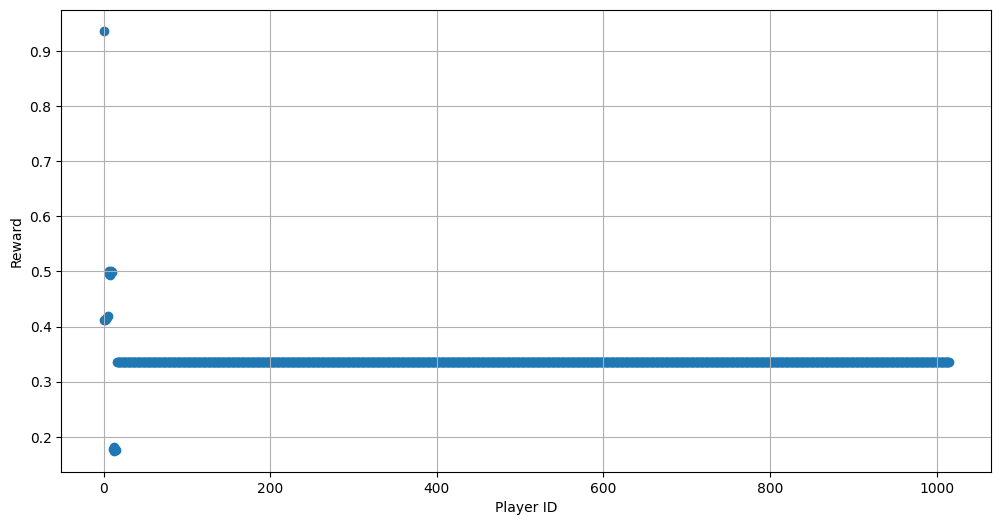

In [208]:
# Plotting the ratings
plt.figure(figsize=(12, 6))
plt.scatter(results_df['PlayerID'], results_df['pess_nn'])
plt.xlabel("Player ID")
plt.ylabel("Reward")
plt.grid(True)

plt.savefig('nn_pess_lin.png')
plt.show()

In [209]:
results_df['pess_nn']

,pess_nn
0,0.936673
1,0.411633
2,0.412589
3,0.412942
4,0.416818
...,...
1011,0.335345
1012,0.335345
1013,0.335345
1014,0.335345


In [210]:
for i in range(d):
    opt = [0 for _ in range(d)]
    opt[i] += 1
    opt = torch.tensor(opt, dtype=torch.float)
    print(reward_net(opt), pess_net(opt))

tensor([-0.4607], grad_fn=<ViewBackward0>) tensor([0.9628], grad_fn=<ViewBackward0>)
tensor([-0.3536], grad_fn=<ViewBackward0>) tensor([0.4120], grad_fn=<ViewBackward0>)
tensor([-0.3066], grad_fn=<ViewBackward0>) tensor([0.4983], grad_fn=<ViewBackward0>)
tensor([-0.5934], grad_fn=<ViewBackward0>) tensor([0.1625], grad_fn=<ViewBackward0>)
tensor([-0.5309], grad_fn=<ViewBackward0>) tensor([0.3353], grad_fn=<ViewBackward0>)


In [211]:
opt = [.2 for _ in range(d)]
opt = torch.tensor(opt, dtype=torch.float)
print(reward_net(opt), pess_net(opt))

tensor([-0.4225], grad_fn=<ViewBackward0>) tensor([0.4840], grad_fn=<ViewBackward0>)


In [190]:
from scipy.stats import norm, binom
p = norm.cdf(0, .1, 0.25)
opt_prob =  binom.cdf(m//2, m, p)
print(1-opt_prob**(n-1))

1.0
